# 实现梯度提升算法（GBDT）

## 目录
* Gradient Boosting算法
* 实现GBDT
* 使用波士顿房价数据来测试实现的GBDT
* GBDT算法与Adaboost算法的对比

## Gradient Boosting算法伪代码  
1. $F_0(x) = argmin_\rho\sum\limits_{i=1}^NL(y_i,\rho)$
2. For m=1 to M do:  
     $\widetilde y_i = -\begin{bmatrix}\frac{\partial L(y_i,F(x_i))}{\partial F(x_i)}\end{bmatrix}_{F(x)=F_{m-1}(x)}, i =1,2,...,M$  
     $a_m = argmin_{\alpha,\beta}\sum\limits_{i=1}^N[\widetilde y_i - \beta h(x_i:\alpha)]^2$  
     $\rho_m = argmin_\rho \sum\limits_{i=1}^N L(y_i,F_{m-1}(x_i)+\rho h(x_i:a_m))$  
     $F_m(x) = F_{m-1}(x) + \rho_m h(x:\alpha_m)$  

3. end For  
4. end Algorithm

采用拟合负梯度的原因在于  
我们的最终目标是：$min L(y,F_m)$  
由于$F_m$是加法模型，故逐步优化F_m，得到使得$min L(y,F_m)$最小的$F_m$  
所以这个过程就类似于梯度下降法，每次$x_t = x_{t-1} - \rho gradient$  
即在每次的$x_{t}$的基础上，加上负梯度，   
故每次的f_m(x)拟合负梯度

## 以决策树为基础，实现以平方误差为损失函数的GBDT

采用的决策树为之前实现的回归树，在原基础上添加max_depth剪枝参数  
伪代码为：   
1. 初始化residual为y值  
2. For i to n_estimators:  
    f_i = createTree(X_train,residual)  
    $\hat y = F_i.predict(X_train)$  
    更新残差值为$y-\hat y$  
    
最终得到GBDT算法的树集合$F_{n_estimators}$

### 构建弱分类器

In [1]:
import numpy as np
import graphviz
class DecisionTreeRegressor():
    
    def __init__(self,min_impurity_decrease=0,min_samples_split=2,min_samples_leaf=1,max_depth=None):
        self.tree = None
        self.min_impurity_decrease = min_impurity_decrease
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        
    def fit(self,X_train,y_train):
        
        
        def leafval(y_train):
            return y_train.mean()#返回叶子节点的值
        
        def Err(y_train):
            return y_train.var()*len(y_train)#返回叶子节点的总方差
        
        def bestsplit(X_train,y_train,min_impurity_decrease,min_samples_split,min_samples_leaf):
            """寻找最佳的切分特征，最佳的切分数据点。如果是叶子节点，则只返回叶子节点的值"""
            if len(set(y_train)) == 1 or len(y_train) < min_samples_split:#如果y_train只有一个值或者y种的样本量小于最小切分值，则不进行分支
                return float(leafval(y_train))
            bestErr = float("inf")
            bestFeature = -1
            bestSplitValue = -1
            for feature in range(X_train.shape[1]):
                colval = set(X_train[:,feature])
                for SplitValue in colval:
                    subleft_index = X_train[:,feature]<=SplitValue
                    yleft = y_train[subleft_index]
                    yright = y_train[~subleft_index]
                    if len(yleft) < min_samples_leaf or len(yright) < min_samples_leaf:
                        continue #如果子节点的个数小于设定值，则进行考虑
                    err = Err(yleft) + Err(yright)
                    if err < bestErr:
                        bestErr = err
                        bestFeature = feature
                        bestSplitValue = SplitValue
            if Err(y_train) - bestErr < min_impurity_decrease or bestFeature == -1:#方差误差下降的足够大或者无法分割
                return float(leafval(y_train))
            else:
                return bestFeature,bestSplitValue
        
        def createTree(X_train,y_train,min_impurity_decrease,min_samples_split,min_samples_leaf,depth,max_depth):
            
            res = bestsplit(X_train,y_train,min_impurity_decrease,min_samples_split,min_samples_leaf)
            if depth == max_depth:
                return leafval(y_train)
            
            if type(res) == float:
                return res
            else:
                tree = {}
                tree["SplitFeature"] = res[0]
                tree["SplitValue"] = res[1]
                left_index = X_train[:,res[0]] <= res[1]
                Xleft,Xright,yleft,yright = X_train[left_index,:],X_train[~left_index,:],y_train[left_index],y_train[~left_index]
                tree["LeftChild"] = createTree(Xleft,yleft,min_impurity_decrease,min_samples_split,min_samples_leaf,depth+1,max_depth)
                tree["RightChild"] = createTree(Xright,yright,min_impurity_decrease,min_samples_split,min_samples_leaf,depth+1,max_depth)
                return tree
        
        self.tree = createTree(X_train,y_train,min_impurity_decrease = self.min_impurity_decrease,min_samples_split = self.min_samples_split,min_samples_leaf = self.min_samples_leaf,depth=1,max_depth=self.max_depth)
        return self            
                    
    def predict(self,X_test):
        RES = np.empty(len(X_test))
        for i in range(len(X_test)):
            RES[i] = self._predict(X_test[i])
        return RES

    def _predict(self,test_data):

        def __predict(tree,test_data):
            if type(tree) != dict: #如果tree只是一个值，则直接返回预测值
                return tree
            else:
                splitfeature = tree["SplitFeature"]
                splitvalue = tree["SplitValue"]
                if test_data[splitfeature] <= splitvalue:
                    return __predict(tree["LeftChild"],test_data)
                else:
                    return __predict(tree["RightChild"],test_data)

        assert self.tree is not None,"fit before predict"
        return __predict(self.tree,test_data)

验证实现的回归树

In [2]:
import pandas as pd
data = np.array(pd.read_csv("ex00.txt",header=None,sep="\t"))
X = data[:,0][:,np.newaxis]
y = data[:,1]
import matplotlib.pyplot as plt
plt.scatter(X,y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

<Figure size 640x480 with 1 Axes>

In [3]:
reg1 = DecisionTreeRegressor(max_depth=2)
reg1.fit(X,y)
reg2 = DecisionTreeRegressor(max_depth=10)
reg2.fit(X,y)

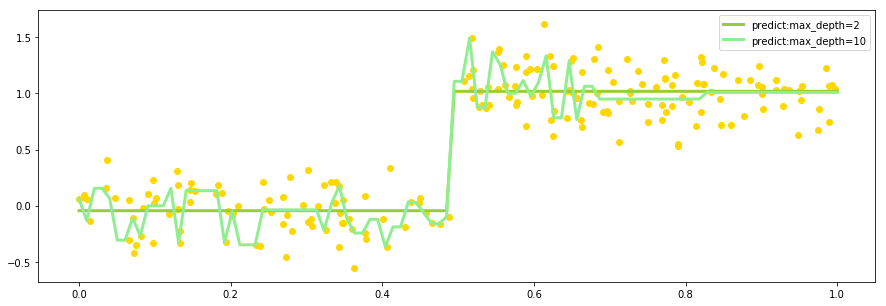

In [4]:
plt.figure(figsize=(15,5))
plt.scatter(X,y,color="gold")
X_plot = np.linspace(0,1,100).reshape(-1,1)
predict1 = reg1.predict(X_plot)
predict2 = reg2.predict(X_plot)
plt.plot(X_plot,predict1,color="yellowgreen",linewidth=3,label='predict:max_depth=2')
plt.plot(X_plot,predict2,color="lightgreen",linewidth=3,label="predict:max_depth=10")
plt.legend()
plt.show()

用回归树的数据验证，说明回归树的构建没有问题

### 构建GBDT

In [5]:
class GBDT():
    def __init__(self,n_estimators,max_depth=None,min_samples_leaf=1,min_samples_split=2):
        self.esemble = []
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split
    
    def fit(self,X_train,y_train):
        residual = y_train
        for i in range(self.n_estimators):
            weakestimator = DecisionTreeRegressor(max_depth=self.max_depth,min_samples_leaf = self.min_samples_leaf,min_samples_split=self.min_samples_split)
            weakestimator.fit(X_train,residual)
            self.esemble.append(weakestimator)
            yhat = weakestimator.predict(X_train)
            residual = residual - yhat
            if (residual**2).sum()<1e-2:
                break
        
    def predict(self,X_test):
        res = np.zeros(len(X_test))
        for i in range(len(self.esemble)):
            res += self.esemble[i].predict(X_test)
        return res
    
    def score(self,X_test,y_test):
        pre = self.predict(X_test)
        return 1 - sum((y_test - pre)**2)/sum((y_test - y_test.mean())**2)

验证实现的GBDT

Text(0.5,1,'the original data')

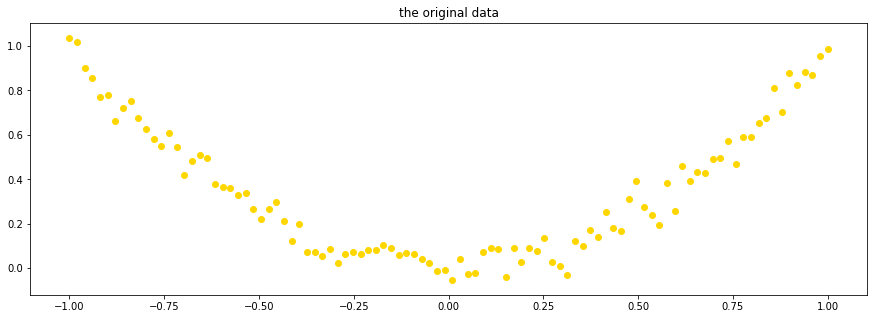

In [6]:
X = np.linspace(-1,1,100).reshape(-1,1)
y = (X**2+np.random.normal(0,0.05,size=X.shape)).flatten()
plt.figure(figsize=(15,5))
plt.scatter(X,y,color="gold")
plt.title("the original data")

In [7]:
reg_GBDT1 = GBDT(n_estimators=1,max_depth=2)
reg_GBDT1.fit(X,y)

reg_GBDT2 = GBDT(n_estimators=3,max_depth=2)
reg_GBDT2.fit(X,y)

reg_GBDT3 = GBDT(n_estimators=10,max_depth=2)
reg_GBDT3.fit(X,y)

pre1 = reg_GBDT1.predict(X)
pre2 = reg_GBDT2.predict(X)
pre3 = reg_GBDT3.predict(X)

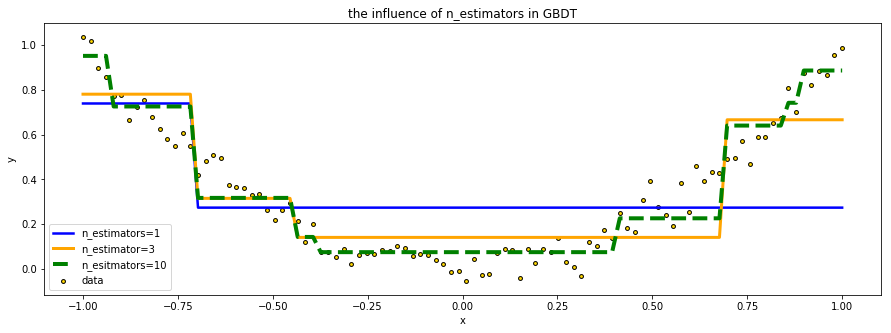

In [8]:
plt.figure(figsize=(15,5))
plt.scatter(X,y,s=15,edgecolors="black",color="gold",label="data")
plt.plot(X,pre1,"b",linewidth=2.5,label="n_estimators=1")
plt.plot(X,pre2,"orange",linewidth=3,label="n_estimator=3")
plt.plot(X,pre3,"g--",linewidth=4,label="n_esitmators=10")
plt.title("the influence of n_estimators in GBDT")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [9]:
reg_GBDT3.score(X,y)

0.9176261070624605

## 使用波士顿房价数据来测试实现的GBDT

In [10]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
bostons = load_boston()
X = bostons.data
y = bostons.target
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [11]:
reg_GBDT = GBDT(n_estimators=15,max_depth=3,min_samples_leaf=20,min_samples_split=30)
reg_GBDT.fit(X_train,y_train)
reg_GBDT.score(X_test,y_test)

0.8078050882643356

In [12]:
reg_GBDT.score(X_train,y_train)

0.9091779405381983

## GBDT算法与Adaboost算法的对比

AdaBoost算法中，使用的是指数损失函数的加法模型。    
模型采用的是分阶段，逐步优化的策略。  
依次训练每一个弱分类器，然后将它加入到已经得到的强学习器中。  
已经训练得到的强学习器对训练样本的输出值可以看作常数。  
因为指数函数的作用，将加法转化为乘法，体现为样本的权重。  
在训练的过程中，在当前权重下训练弱学习器，然后更新样本权重。

梯度提升算法的思路是不同的，它不是给样本加上权重，而是在样本的拟合目标上做文章。   
用当前已经训练出来的强学习器F(x)对训练样本进行预测，  
然后计算损失函数对F(x)的负梯度值,  
如果下一个弱学习器h(x;a)的预测值指向该负梯度方向，根据梯度下降法的原理，加上这个弱学习器，即向前走一步，损失函数值是下降的。  
梯度提升算法可以看作是梯度下降法与加法模型的结合。